## Sea Ice Diagnostics for two CESM3 runs

In [1]:
import xarray as xr
import numpy as np
import yaml
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
CESM_output_dir = "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CESM_output_for_testing"
serial = False  # use dask LocalCluster
cases = [
    "b.e23_alpha17f.BLTHIST.ne30_t232.092",
    "b.e30_beta02.BLTHIST.ne30_t232.104",
]

lc_kwargs = {}

begyr1 = 1850
endyr1 = 2013
begyr2 = 1850
endyr2 = 2013
nyears = 35

In [5]:
from dask.distributed import Client
from dask_jobqueue import PBSCluster

cluster = PBSCluster(cores=16,processes=16,memory='100GB',project='P93300665',queue='casper',walltime='02:00:00')

client = Client(cluster)

cluster.scale(1)

print(cluster)
print(client)

PBSCluster(c815359e, 'tcp://128.117.208.112:42003', workers=0, threads=0, memory=0 B)
<Client: 'tcp://128.117.208.112:42003' processes=0 threads=0, memory=0 B>


/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37833 instead
  warnings.warn(


In [6]:
#from dask.distributed import Client, LocalCluster

# Spin up cluster (if running in parallel)
#client = None
#if not serial:
#    cluster = LocalCluster(**lc_kwargs)
#    client = Client(cluster)

#client

In [14]:
# Read in two cases. The ADF timeseries are needed here.

case1 = cases[0]
case2 = cases[1]

cbegyr1 = f"{begyr1:04d}"
cendyr1 = f"{endyr1:04d}"
cbegyr2 = f"{begyr2:04d}"
cendyr2 = f"{endyr2:04d}"

ds1 = xr.open_mfdataset(
    CESM_output_dir
    + "/"
    + case1
    + "/ice/proc/tseries/month_1/"
    + case1
    + ".cice.h."
    + "*."
    + cbegyr1
    + "01-"
    + cendyr1
    + "02.nc",
    data_vars="minimal",
    compat="override",
    coords="minimal",
)
ds2 = xr.open_mfdataset(
    CESM_output_dir
    + "/"
    + case2
    + "/ice/proc/tseries/month_1/"
    + case2
    + ".cice.h."
    + "*."
    + cbegyr2
    + "01-"
    + cendyr2
    + "12.nc",
    data_vars="minimal",
    compat="override",
    coords="minimal",
)

ds_grid = xr.open_dataset("/glade/campaign/cesm/community/omwg/grids/tx2_3v2_grid.nc")
TLAT = ds_grid["TLAT"]
TLON = ds_grid["TLONG"]
tarea = ds_grid["TAREA"]*1.0e-4
angle = ds_grid["ANGLE"]

# Make a DataArray with the number of days in each month, size = len(time)
month_length = ds1.time.dt.days_in_month
weights_monthly = (
    month_length.groupby("time.year") / month_length.groupby("time.year").sum()
)


# seasons = xr.full_like(months, fill_value="none", dtype="U4")
# seasons.name = "season"
# seasons[months.isin([1, 2, 3])] = "JFM"
# seasons[months.isin([4, 5, 6])] = "AMJ"
# seasons[months.isin([7, 8, 9])] = "JAS"
# seasons[months.isin([10, 11, 12])] = "OND"
# weights_season = month_length.groupby(seasons) / month_length.groupby(seasons).sum()

ds1_ann = (ds1 * weights_monthly).resample(time="YS").sum(dim="time")
ds2_ann = (ds2 * weights_monthly).resample(time="YS").sum(dim="time")


# ds1_seas = (ds1 * weights_season).resample(time="QS-JAN").sum(dim="time")
# ds2_seas = (ds2 * weights_season).resample(time="QS-JAN").sum(dim="time")

with open("cice_masks.yml", "r") as file:
    cice_masks = yaml.safe_load(file)

with open("cice_vars.yml", "r") as file:
    cice_vars = yaml.safe_load(file)

print(ds1["aice"])

<xarray.DataArray 'aice' (time: 1958, nj: 480, ni: 540)>
dask.array<open_dataset-aice, shape=(1958, 480, 540), dtype=float32, chunksize=(2, 480, 540), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2013-02-15 00:00:00
    TLON     (nj, ni) float32 dask.array<chunksize=(480, 540), meta=np.ndarray>
    TLAT     (nj, ni) float32 dask.array<chunksize=(480, 540), meta=np.ndarray>
    ULON     (nj, ni) float32 dask.array<chunksize=(480, 540), meta=np.ndarray>
    ULAT     (nj, ni) float32 dask.array<chunksize=(480, 540), meta=np.ndarray>
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged


In [15]:
from plot_diff import plot_diff
from vect_diff import vect_diff

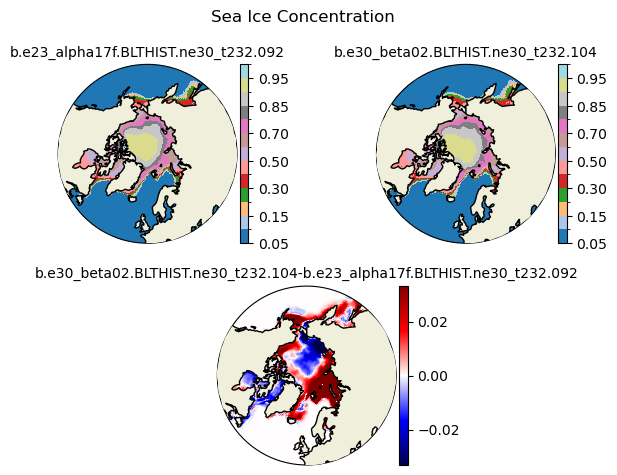

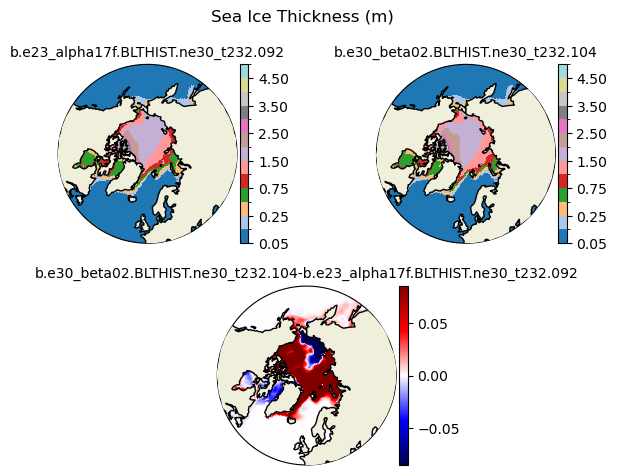

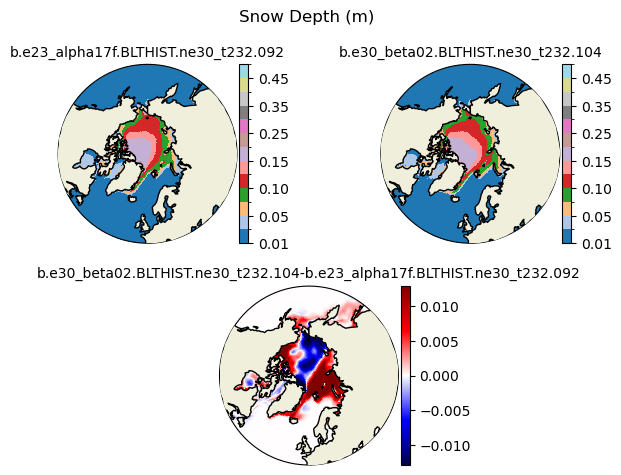

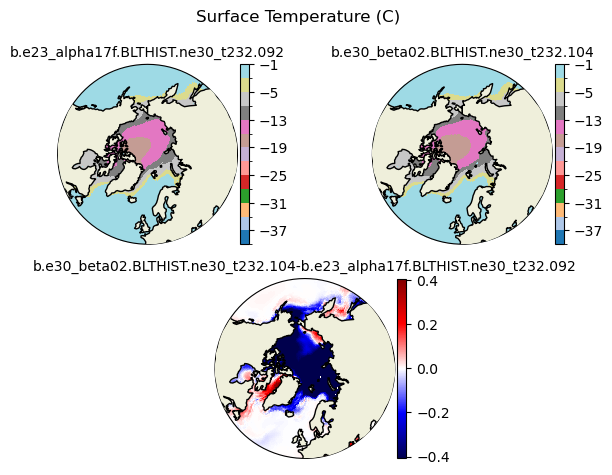

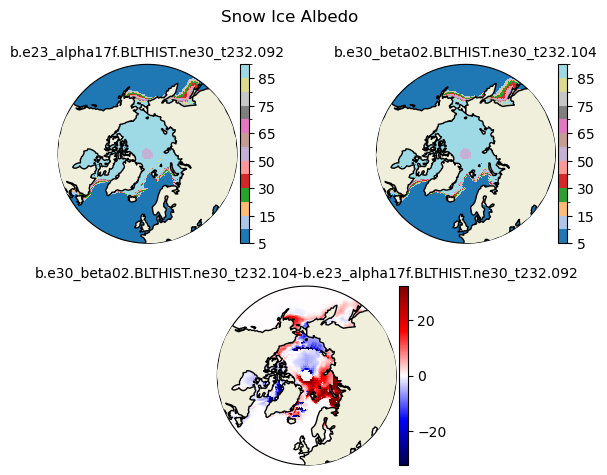

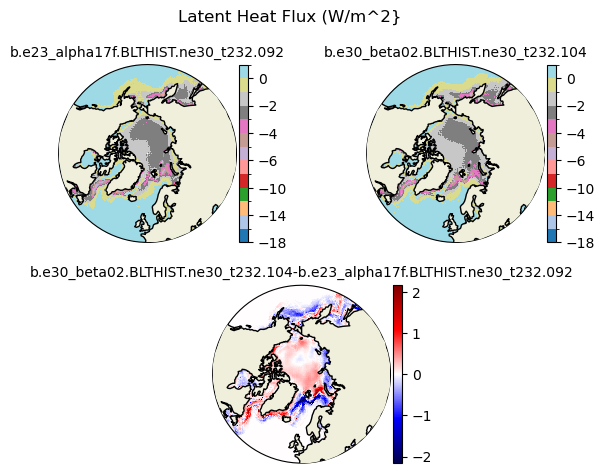

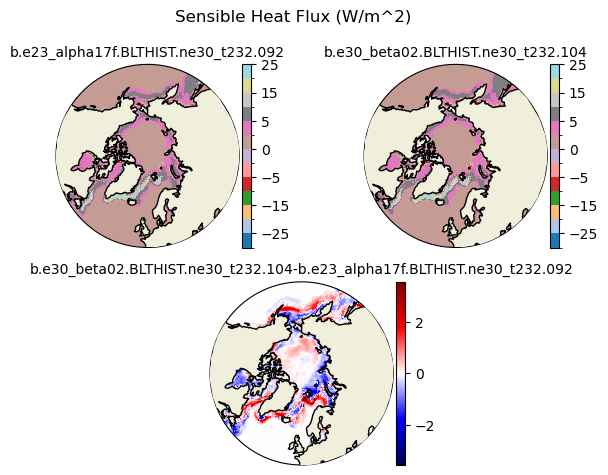

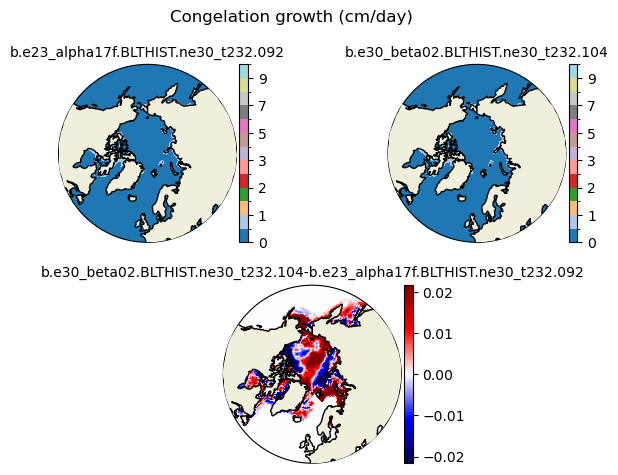

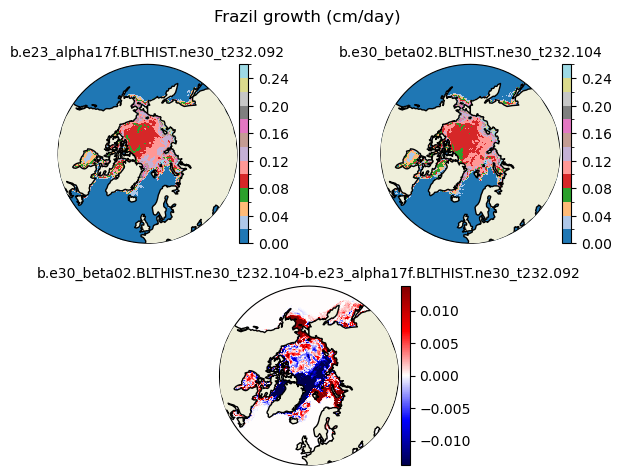

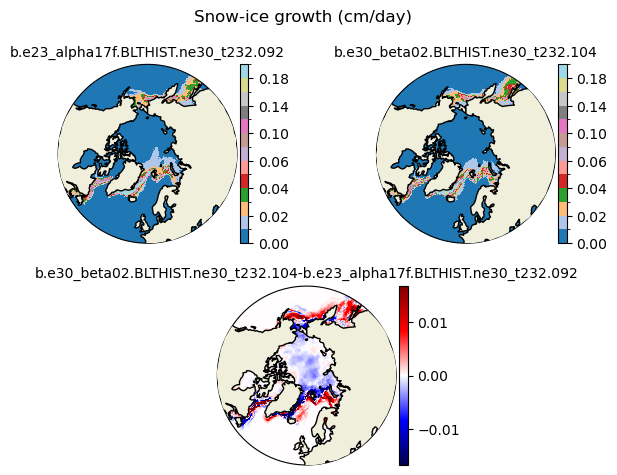

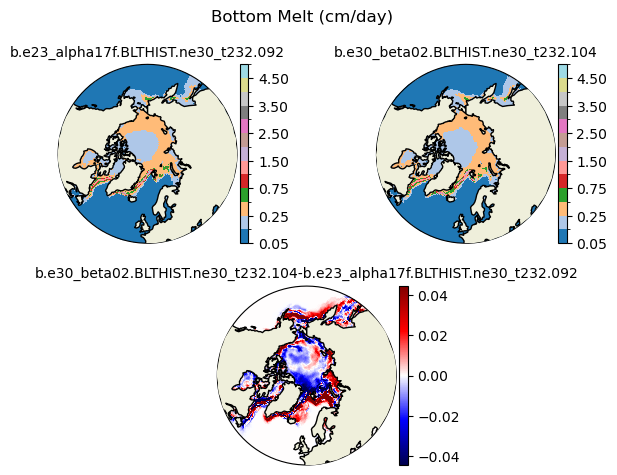

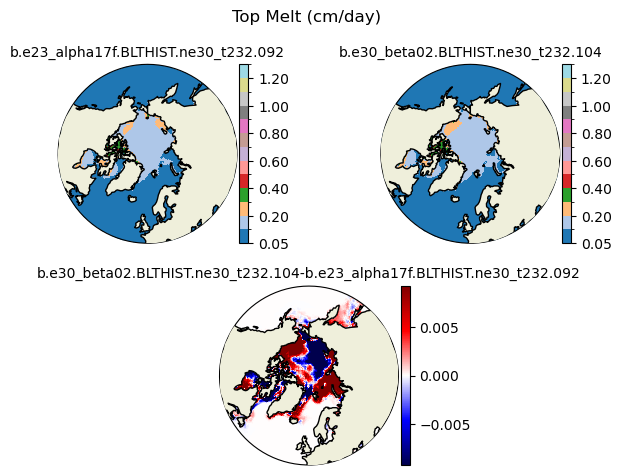

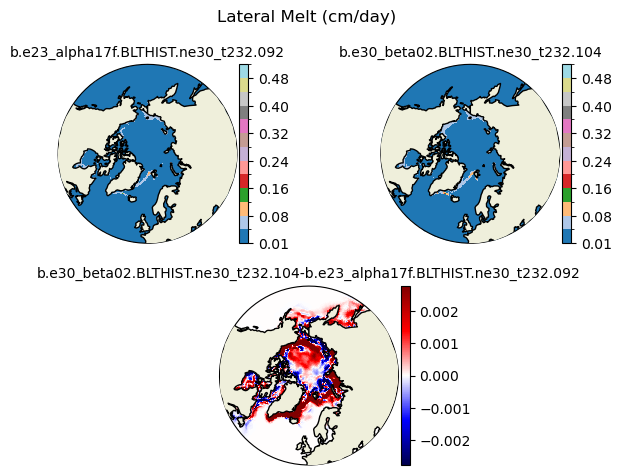

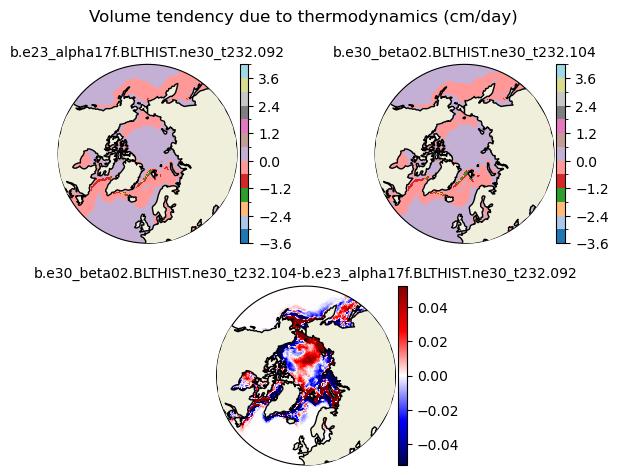

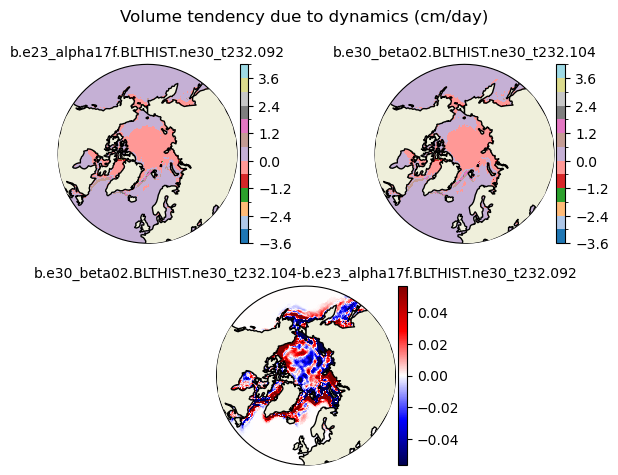

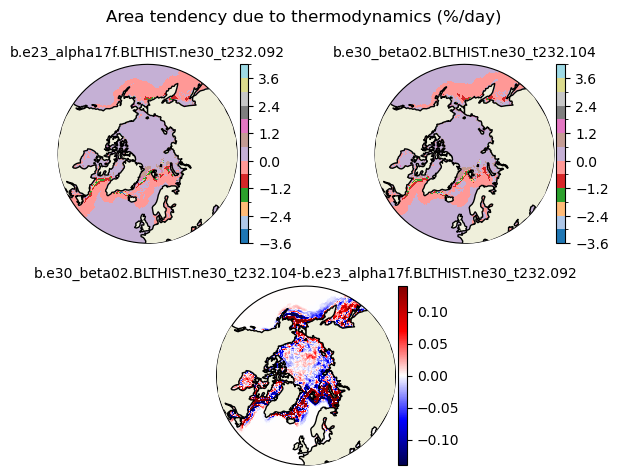

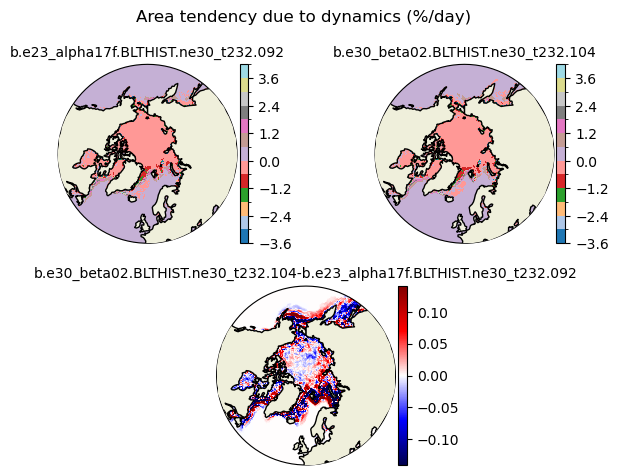

In [13]:
for var in cice_vars:
    vmin = cice_vars[var][0]["levels"][0]
    vmax = cice_vars[var][0]["levels"][-1]
    levels = np.array(cice_vars[var][0]["levels"])
    title = cice_vars[var][1]["title"]
    field1 = ds1_ann[var].isel(time=slice(-nyears, None)).mean("time").squeeze()
    field2 = ds2_ann[var].isel(time=slice(-nyears, None)).mean("time").squeeze()
    plot_diff(field1, field2, levels, case1, case2, title, "N", TLAT, TLON)

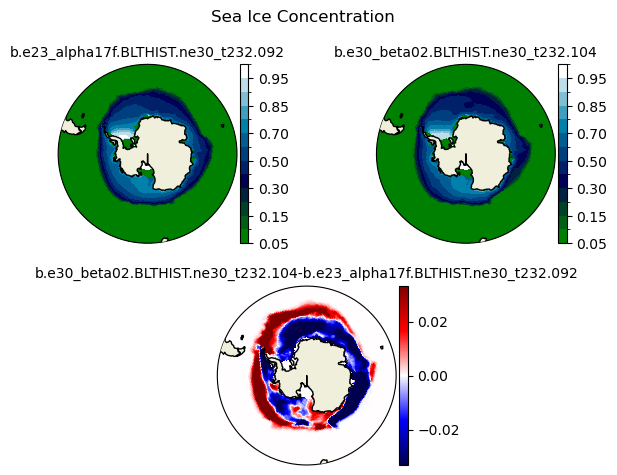

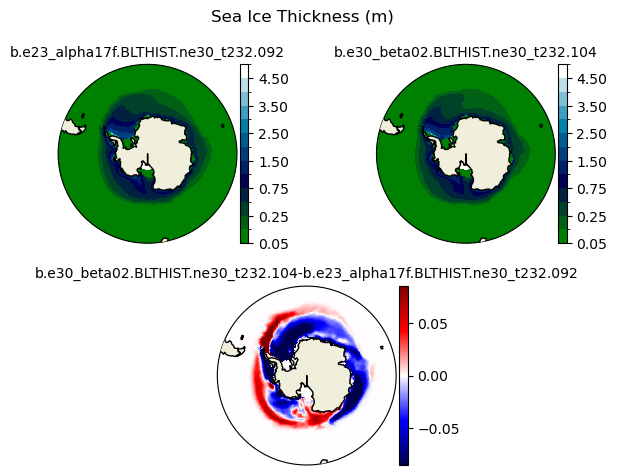

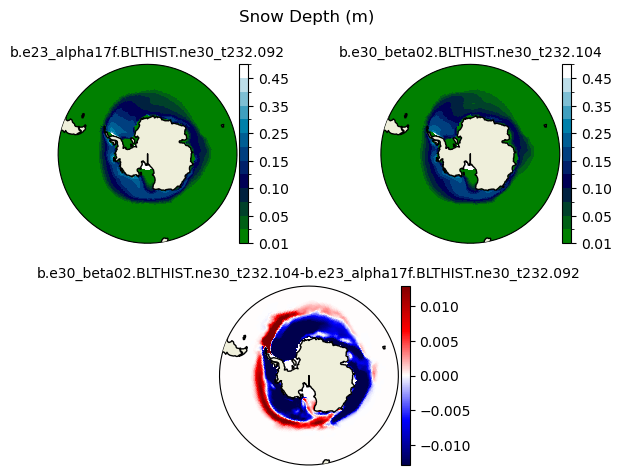

In [15]:
for var in cice_vars:
    vmin = cice_vars[var][0]["levels"][0]
    vmax = cice_vars[var][0]["levels"][1]
    levels = np.array(cice_vars[var][0]["levels"])
    title = cice_vars[var][1]["title"]
    field1 = ds1_ann[var].isel(time=slice(-nyears, None)).mean("time").squeeze()
    field2 = ds2_ann[var].isel(time=slice(-nyears, None)).mean("time").squeeze()
    plot_diff(field1, field2, levels, case1, case2, title, "S", TLAT, TLON)

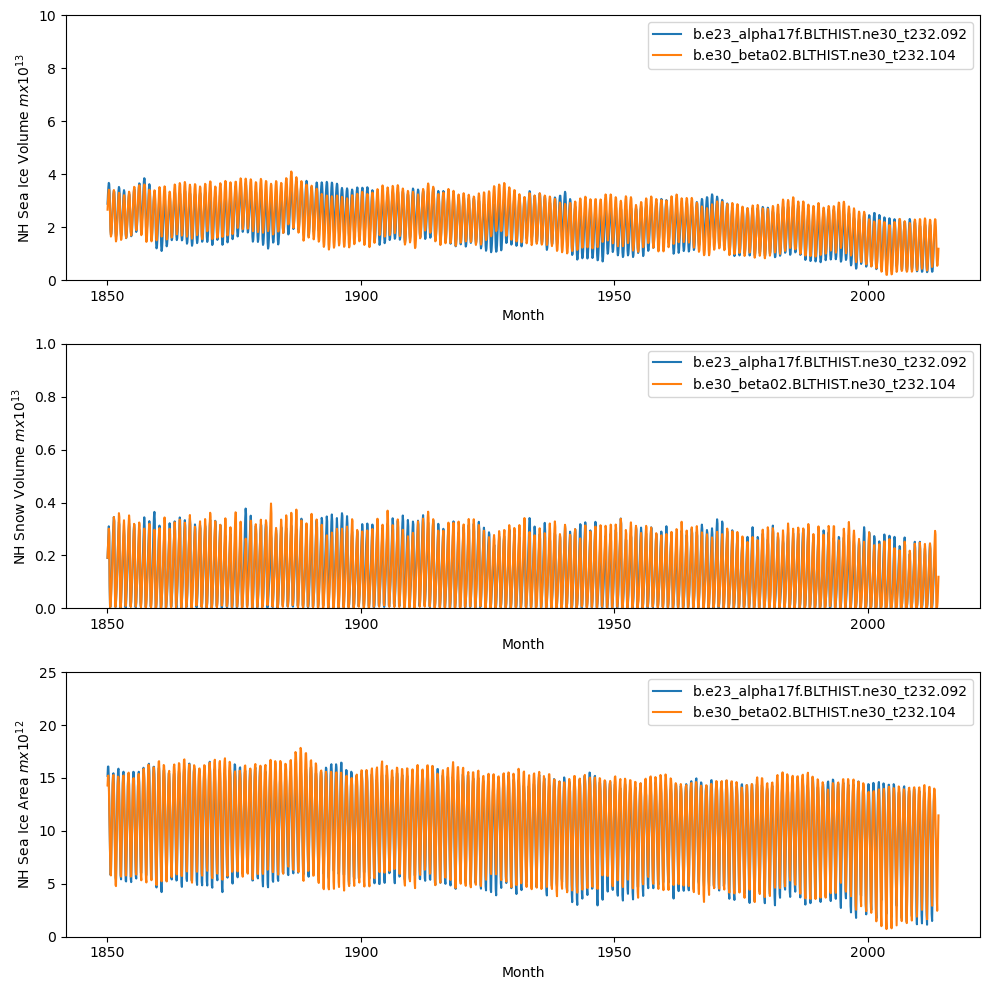

In [16]:
ds1_area = (tarea * ds1.aice).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-12
ds2_area = (tarea * ds2.aice).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-12

ds1_vhi = (tarea * ds1.hi).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-13
ds2_vhi = (tarea * ds2.hi).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-13

ds1_vhs = (tarea * ds1.hs).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-13
ds2_vhs = (tarea * ds2.hs).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-13

fig = plt.figure(figsize=(10, 10), tight_layout=True)

ax = fig.add_subplot(3, 1, 1)
ds1_vhi.plot()
ds2_vhi.plot()

plt.ylim((0, 10))
plt.xlabel("Month")
plt.ylabel("NH Sea Ice Volume $m x 10^{13}$")
plt.legend([case1, case2])

ax = fig.add_subplot(3, 1, 2)
ds1_vhs.plot()
ds2_vhs.plot()

plt.ylim((0, 1))
plt.xlabel("Month")
plt.ylabel("NH Snow Volume $m x 10^{13}$")
plt.legend([case1, case2])

ax = fig.add_subplot(3, 1, 3)
ds1_area.plot()
ds2_area.plot()

plt.ylim((0, 25))
plt.xlabel("Month")
plt.ylabel("NH Sea Ice Area $m x 10^{12}$")
plt.legend([case1, case2])

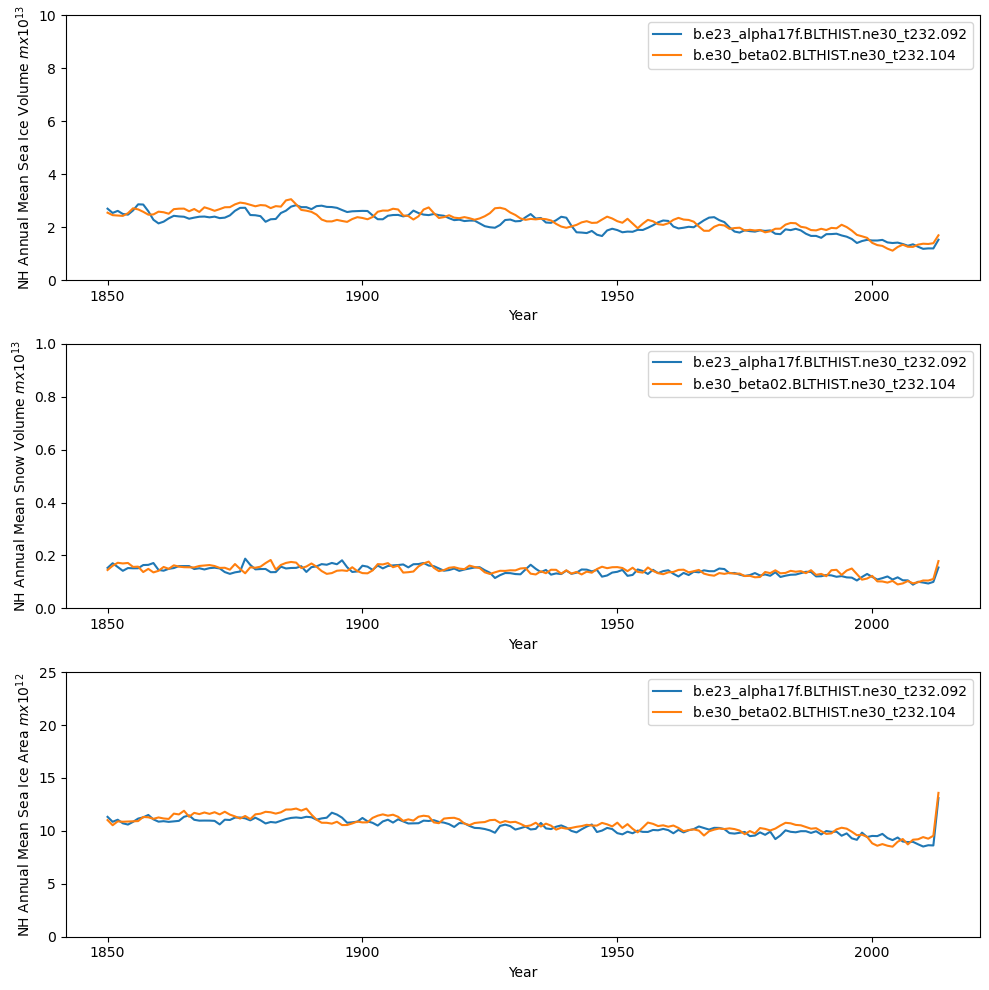

In [17]:
ds1_area_ann = (tarea * ds1_ann["aice"]).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-12
ds2_area_ann = (tarea * ds2_ann["aice"]).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-12

ds1_vhi_ann = (tarea * ds1_ann["hi"]).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-13
ds2_vhi_ann = (tarea * ds2_ann["hi"]).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-13

ds1_vhs_ann = (tarea * ds1_ann["hs"]).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-13
ds2_vhs_ann = (tarea * ds2_ann["hs"]).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-13

fig = plt.figure(figsize=(10, 10), tight_layout=True)

ax = fig.add_subplot(3, 1, 1)
ds1_vhi_ann.plot()
ds2_vhi_ann.plot()

plt.ylim((0, 10))
plt.xlabel("Year")
plt.ylabel("NH Annual Mean Sea Ice Volume $m x 10^{13}$")
plt.legend([case1, case2])

ax = fig.add_subplot(3, 1, 2)
ds1_vhs_ann.plot()
ds2_vhs_ann.plot()

plt.ylim((0, 1))
plt.xlabel("Year")
plt.ylabel("NH Annual Mean Snow Volume $m x 10^{13}$")
plt.legend([case1, case2])

ax = fig.add_subplot(3, 1, 3)
ds1_area_ann.plot()
ds2_area_ann.plot()

plt.ylim((0, 25))
plt.xlabel("Year")
plt.ylabel("NH Annual Mean Sea Ice Area $m x 10^{12}$")
plt.legend([case1, case2])

ds1_area.sel(time=ds1_area.time.dt.month.isin([10])).plot()
ds2_area.sel(time=ds2_area.time.dt.month.isin([10])).plot()

plt.ylim((0,25))
plt.xlabel("Year")
plt.ylabel("NH September Sea Ice Area $m x 10^{12}$")
plt.legend([case1,case2])

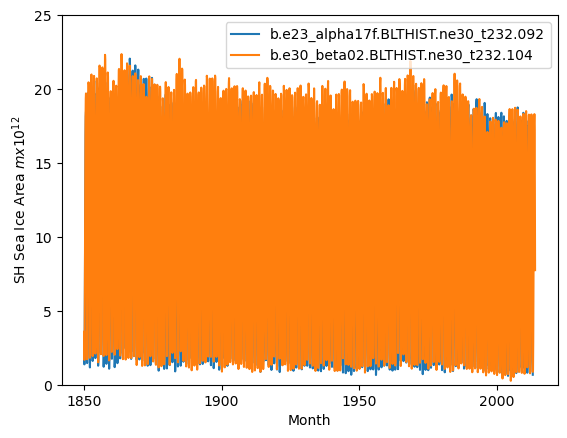

In [18]:
ds1_area = (tarea * ds1.aice).where(TLAT < 0).sum(dim=["nj", "ni"]) * 1.0e-12
ds2_area = (tarea * ds2.aice).where(TLAT < 0).sum(dim=["nj", "ni"]) * 1.0e-12

ds1_area.plot()
ds2_area.plot()

plt.ylim((0, 25))
plt.xlabel("Month")
plt.ylabel("SH Sea Ice Area $m x 10^{12}$")
plt.legend([case1, case2])

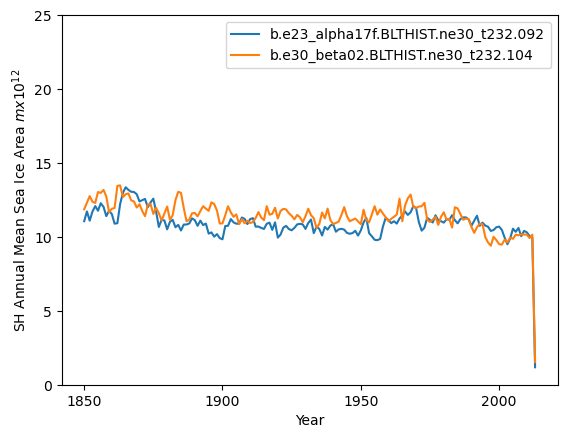

In [19]:
ds1_area_ann = (tarea * ds1_ann.aice).where(TLAT < 0).sum(dim=["nj", "ni"]) * 1.0e-12
ds2_area_ann = (tarea * ds2_ann.aice).where(TLAT < 0).sum(dim=["nj", "ni"]) * 1.0e-12

ds1_area_ann.plot()
ds2_area_ann.plot()

plt.ylim((0, 25))
plt.xlabel("Year")
plt.ylabel("SH Annual Mean Sea Ice Area $m x 10^{12}$")
plt.legend([case1, case2])

[13.67 13.34 13.59 13.34 13.64 13.3  12.99 13.05 13.22   nan 13.63 13.39
 13.11 12.95 13.41 13.32 13.27 12.92 12.86 13.08 12.76 12.64 12.64 12.49
 12.61 12.59 12.55 12.23 11.95 12.03 12.36 12.2  11.83 12.15 12.01 12.18
 12.35 12.04 11.46 11.74 11.86]


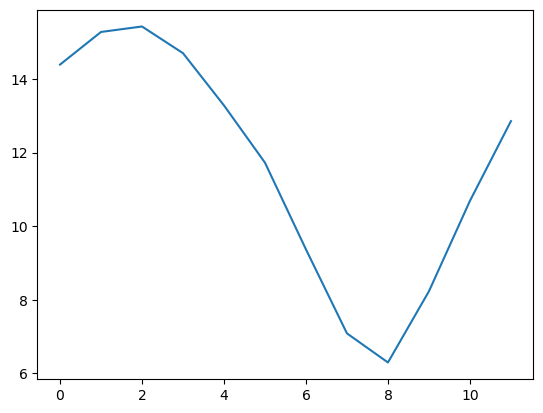

In [20]:
### Read in the NSIDC data from files

path_nsidc = "/glade/campaign/cesm/development/pcwg/ice/data/NSIDC_SeaIce_extent/"

jan_nsidc = pd.read_csv(path_nsidc + "N_01_extent_v3.0.csv", na_values=["-99.9"])
feb_nsidc = pd.read_csv(path_nsidc + "N_02_extent_v3.0.csv", na_values=["-99.9"])
mar_nsidc = pd.read_csv(path_nsidc + "N_03_extent_v3.0.csv", na_values=["-99.9"])
apr_nsidc = pd.read_csv(path_nsidc + "N_04_extent_v3.0.csv", na_values=["-99.9"])
may_nsidc = pd.read_csv(path_nsidc + "N_05_extent_v3.0.csv", na_values=["-99.9"])
jun_nsidc = pd.read_csv(path_nsidc + "N_06_extent_v3.0.csv", na_values=["-99.9"])
jul_nsidc = pd.read_csv(path_nsidc + "N_07_extent_v3.0.csv", na_values=["-99.9"])
aug_nsidc = pd.read_csv(path_nsidc + "N_08_extent_v3.0.csv", na_values=["-99.9"])
sep_nsidc = pd.read_csv(path_nsidc + "N_09_extent_v3.0.csv", na_values=["-99.9"])
oct_nsidc = pd.read_csv(path_nsidc + "N_10_extent_v3.0.csv", na_values=["-99.9"])
nov_nsidc = pd.read_csv(path_nsidc + "N_11_extent_v3.0.csv", na_values=["-99.9"])
dec_nsidc = pd.read_csv(path_nsidc + "N_12_extent_v3.0.csv", na_values=["-99.9"])

jan_area = jan_nsidc.iloc[:, 5].values
feb_area = feb_nsidc.iloc[:, 5].values
mar_area = mar_nsidc.iloc[:, 5].values
apr_area = apr_nsidc.iloc[:, 5].values
may_area = may_nsidc.iloc[:, 5].values
jun_area = jun_nsidc.iloc[:, 5].values
jul_area = jul_nsidc.iloc[:, 5].values
aug_area = aug_nsidc.iloc[:, 5].values
sep_area = sep_nsidc.iloc[:, 5].values
oct_area = oct_nsidc.iloc[:, 5].values
nov_area = nov_nsidc.iloc[:, 5].values
dec_area = dec_nsidc.iloc[:, 5].values

jan_ext = jan_nsidc.iloc[:, 4].values
feb_ext = feb_nsidc.iloc[:, 4].values
mar_ext = mar_nsidc.iloc[:, 4].values
apr_ext = apr_nsidc.iloc[:, 4].values
may_ext = may_nsidc.iloc[:, 4].values
jun_ext = jun_nsidc.iloc[:, 4].values
jul_ext = jul_nsidc.iloc[:, 4].values
aug_ext = aug_nsidc.iloc[:, 4].values
sep_ext = sep_nsidc.iloc[:, 4].values
oct_ext = oct_nsidc.iloc[:, 4].values
nov_ext = nov_nsidc.iloc[:, 4].values
dec_ext = dec_nsidc.iloc[:, 4].values

print(dec_ext)
nsidc_clim = [
    np.nanmean(jan_ext[0:35]),
    np.nanmean(feb_ext[0:35]),
    np.nanmean(mar_ext[0:35]),
    np.nanmean(apr_ext[0:35]),
    np.nanmean(may_ext[0:35]),
    np.nanmean(jun_ext[0:35]),
    np.nanmean(jul_ext[0:35]),
    np.nanmean(aug_ext[0:35]),
    np.nanmean(sep_ext[0:35]),
    np.nanmean(oct_ext[0:35]),
    np.nanmean(nov_ext[0:35]),
    np.nanmean(dec_ext[0:35]),
]

plt.plot(nsidc_clim)

[10.4   9.24 10.16 10.89  9.22 10.39 10.47 11.35  9.65   nan 11.06  9.84
  9.95 10.19 10.21  9.93 10.1  10.62  9.65 10.29 10.52 10.72  9.91 10.35
 10.79 10.56 10.23  9.68  9.85 11.98 11.51 10.74 11.27 11.2  10.39 11.85
 11.93 10.66  8.28  9.48  9.03]


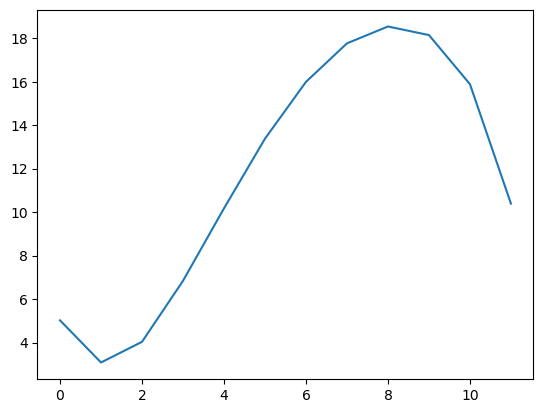

In [21]:
### Read in the SH NSIDC data from files

path_nsidc = "/glade/campaign/cesm/development/pcwg/ice/data/NSIDC_SeaIce_extent/"

jan_nsidc_sh = pd.read_csv(path_nsidc + "S_01_extent_v3.0.csv", na_values=["-99.9"])
feb_nsidc_sh = pd.read_csv(path_nsidc + "S_02_extent_v3.0.csv", na_values=["-99.9"])
mar_nsidc_sh = pd.read_csv(path_nsidc + "S_03_extent_v3.0.csv", na_values=["-99.9"])
apr_nsidc_sh = pd.read_csv(path_nsidc + "S_04_extent_v3.0.csv", na_values=["-99.9"])
may_nsidc_sh = pd.read_csv(path_nsidc + "S_05_extent_v3.0.csv", na_values=["-99.9"])
jun_nsidc_sh = pd.read_csv(path_nsidc + "S_06_extent_v3.0.csv", na_values=["-99.9"])
jul_nsidc_sh = pd.read_csv(path_nsidc + "S_07_extent_v3.0.csv", na_values=["-99.9"])
aug_nsidc_sh = pd.read_csv(path_nsidc + "S_08_extent_v3.0.csv", na_values=["-99.9"])
sep_nsidc_sh = pd.read_csv(path_nsidc + "S_09_extent_v3.0.csv", na_values=["-99.9"])
oct_nsidc_sh = pd.read_csv(path_nsidc + "S_10_extent_v3.0.csv", na_values=["-99.9"])
nov_nsidc_sh = pd.read_csv(path_nsidc + "S_11_extent_v3.0.csv", na_values=["-99.9"])
dec_nsidc_sh = pd.read_csv(path_nsidc + "S_12_extent_v3.0.csv", na_values=["-99.9"])

jan_area_sh = jan_nsidc_sh.iloc[:, 5].values
feb_area_sh = feb_nsidc_sh.iloc[:, 5].values
mar_area_sh = mar_nsidc_sh.iloc[:, 5].values
apr_area_sh = apr_nsidc_sh.iloc[:, 5].values
may_area_sh = may_nsidc_sh.iloc[:, 5].values
jun_area_sh = jun_nsidc_sh.iloc[:, 5].values
jul_area_sh = jul_nsidc_sh.iloc[:, 5].values
aug_area_sh = aug_nsidc_sh.iloc[:, 5].values
sep_area_sh = sep_nsidc_sh.iloc[:, 5].values
oct_area_sh = oct_nsidc_sh.iloc[:, 5].values
nov_area_sh = nov_nsidc_sh.iloc[:, 5].values
dec_area_sh = dec_nsidc_sh.iloc[:, 5].values

jan_ext_sh = jan_nsidc_sh.iloc[:, 4].values
feb_ext_sh = feb_nsidc_sh.iloc[:, 4].values
mar_ext_sh = mar_nsidc_sh.iloc[:, 4].values
apr_ext_sh = apr_nsidc_sh.iloc[:, 4].values
may_ext_sh = may_nsidc_sh.iloc[:, 4].values
jun_ext_sh = jun_nsidc_sh.iloc[:, 4].values
jul_ext_sh = jul_nsidc_sh.iloc[:, 4].values
aug_ext_sh = aug_nsidc_sh.iloc[:, 4].values
sep_ext_sh = sep_nsidc_sh.iloc[:, 4].values
oct_ext_sh = oct_nsidc_sh.iloc[:, 4].values
nov_ext_sh = nov_nsidc_sh.iloc[:, 4].values
dec_ext_sh = dec_nsidc_sh.iloc[:, 4].values

print(dec_ext_sh)
nsidc_clim_sh = [
    np.nanmean(jan_ext_sh[0:35]),
    np.nanmean(feb_ext_sh[0:35]),
    np.nanmean(mar_ext_sh[0:35]),
    np.nanmean(apr_ext_sh[0:35]),
    np.nanmean(may_ext_sh[0:35]),
    np.nanmean(jun_ext_sh[0:35]),
    np.nanmean(jul_ext_sh[0:35]),
    np.nanmean(aug_ext_sh[0:35]),
    np.nanmean(sep_ext_sh[0:35]),
    np.nanmean(oct_ext_sh[0:35]),
    np.nanmean(nov_ext_sh[0:35]),
    np.nanmean(dec_ext_sh[0:35]),
]

plt.plot(nsidc_clim_sh)

<xarray.DataArray 'aice' (time: 1958, nj: 480, ni: 540)>
dask.array<open_dataset-aice, shape=(1958, 480, 540), dtype=float32, chunksize=(2, 480, 540), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2013-02-15 00:00:00
    TLON     (nj, ni) float32 dask.array<chunksize=(480, 540), meta=np.ndarray>
    TLAT     (nj, ni) float32 dask.array<chunksize=(480, 540), meta=np.ndarray>
    ULON     (nj, ni) float32 dask.array<chunksize=(480, 540), meta=np.ndarray>
    ULAT     (nj, ni) float32 dask.array<chunksize=(480, 540), meta=np.ndarray>
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged


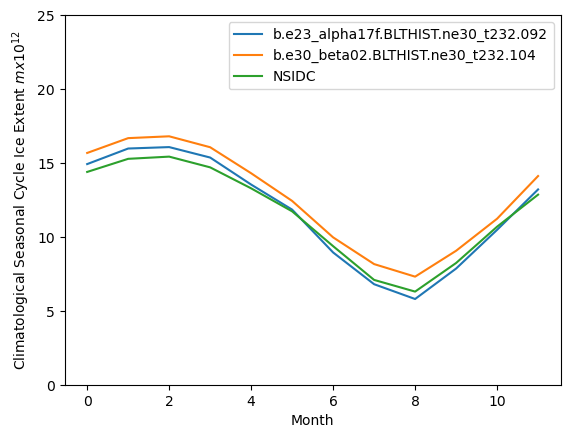

In [23]:
print(ds1['aice'])

aice1_month = ds1["aice"][1535:1955,:,:].groupby("time.month").mean(dim="time", skipna=True)
aice2_month = ds2["aice"][923:1343,:,:].groupby("time.month").mean(dim="time", skipna=True)

mask_tmp1 = np.where(np.logical_and(aice1_month > 0.15, ds1["TLAT"] > 0), 1.0, 0.0)
mask_tmp2 = np.where(np.logical_and(aice2_month > 0.15, ds1["TLAT"] > 0), 1.0, 0.0)

mask_ext1 = xr.DataArray(data=mask_tmp1, dims=["month", "nj", "ni"])
mask_ext2 = xr.DataArray(data=mask_tmp2, dims=["month", "nj", "ni"])


ext1 = (mask_ext1 * tarea).sum(["ni", "nj"]) * 1.0e-12
ext2 = (mask_ext2 * tarea).sum(["ni", "nj"]) * 1.0e-12

plt.plot(ext1)
plt.plot(ext2)
plt.plot(nsidc_clim)

plt.ylim((0, 25))
plt.xlabel("Month")
plt.ylabel("Climatological Seasonal Cycle Ice Extent $m x 10^{12}$")
plt.legend([case1, case2, "NSIDC"])

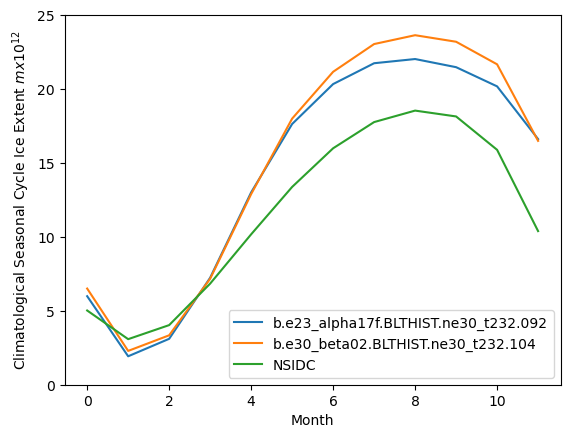

In [24]:

mask_tmp1_sh = np.where(np.logical_and(aice1_month > 0.15, ds1["TLAT"] < 0), 1.0, 0.0)
mask_tmp2_sh = np.where(np.logical_and(aice2_month > 0.15, ds1["TLAT"] < 0), 1.0, 0.0)

mask_ext1_sh = xr.DataArray(data=mask_tmp1_sh, dims=["month", "nj", "ni"])
mask_ext2_sh = xr.DataArray(data=mask_tmp2_sh, dims=["month", "nj", "ni"])


ext1_sh = (mask_ext1_sh * tarea).sum(["ni", "nj"]) * 1.0e-12
ext2_sh = (mask_ext2_sh * tarea).sum(["ni", "nj"]) * 1.0e-12

plt.plot(ext1_sh)
plt.plot(ext2_sh)
plt.plot(nsidc_clim_sh)

plt.ylim((0, 25))
plt.xlabel("Month")
plt.ylabel("Climatological Seasonal Cycle Ice Extent $m x 10^{12}$")
plt.legend([case1, case2, "NSIDC"])

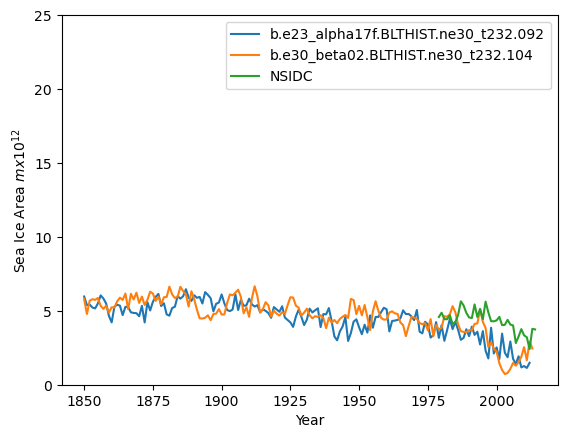

In [25]:
ds1_area = (tarea * ds1.aice).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-12
ds2_area = (tarea * ds2.aice).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-12

ds1_sep = ds1_area.sel(time=(ds1_area.time.dt.month == 9))
ds2_sep = ds2_area.sel(time=(ds2_area.time.dt.month == 9))

x1=np.linspace(1850,2012,163)
x2=np.linspace(1850,2013,164)
x3=np.linspace(1979,2014,36)

plt.plot(x1,ds1_sep)
plt.plot(x2,ds2_sep)
plt.plot(x3,sep_area[0:36])

plt.ylim((0, 25))
plt.xlabel("Year")
plt.ylabel("Sea Ice Area $mx10^{12}$")
plt.legend([case1, case2, "NSIDC"])

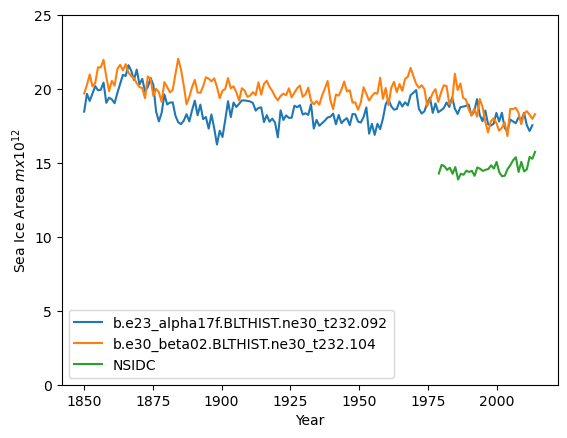

In [26]:
ds1_area_sh = (tarea * ds1.aice).where(TLAT < 0).sum(dim=["nj", "ni"]) * 1.0e-12
ds2_area_sh = (tarea * ds2.aice).where(TLAT < 0).sum(dim=["nj", "ni"]) * 1.0e-12

ds1_feb_sh = ds1_area_sh.sel(time=(ds1_area_sh.time.dt.month == 2))
ds2_feb_sh = ds2_area_sh.sel(time=(ds2_area_sh.time.dt.month == 2))

ds1_sep_sh = ds1_area_sh.sel(time=(ds1_area_sh.time.dt.month == 9))
ds2_sep_sh = ds2_area_sh.sel(time=(ds2_area_sh.time.dt.month == 9))

x1=np.linspace(1850,2013,163)
x2=np.linspace(1850,2014,164)
x3=np.linspace(1979,2014,36)

plt.plot(x1,ds1_sep_sh)
plt.plot(x2,ds2_sep_sh)
plt.plot(x3,sep_area_sh[0:36])

plt.ylim((0, 25))
plt.xlabel("Year")
plt.ylabel("Sea Ice Area $mx10^{12}$")
plt.legend([case1, case2, "NSIDC"])

In [ ]:
latm = cice_masks["Lab_lat"]
lonm = cice_masks["Lab_lon"]

lon = np.where(TLON < 0, TLON + 360.0, TLON)

mask1 = np.where(np.logical_and(TLAT > latm[0], TLAT < latm[1]), 1.0, 0.0)
mask2 = np.where(np.logical_or(lon > lonm[0], lon < lonm[1]), 1.0, 0.0)
mask = mask1 * mask2

ds1_lab = (mask * tarea * ds1.aice).sum(dim=["nj", "ni"]) * 1.0e-12
ds2_lab = (mask * tarea * ds2.aice).sum(dim=["nj", "ni"]) * 1.0e-12

ds1_lab.plot()
ds2_lab.plot()

plt.ylim((0, 10))
plt.xlabel("Month")
plt.ylabel("Labrador Sea Ice Area $m x 10^{12}$")
plt.legend([case1, case2])

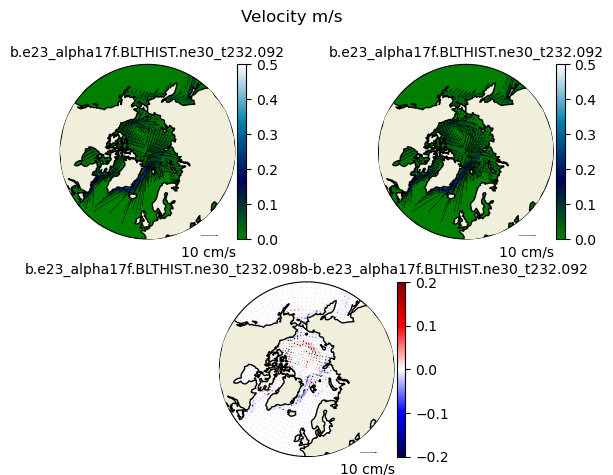

In [25]:
uvel1 = ds1_ann["uvel"].isel(time=slice(-nyears, None)).mean("time").squeeze()
vvel1 = ds1_ann["vvel"].isel(time=slice(-nyears, None)).mean("time").squeeze()
uvel2 = ds2_ann["uvel"].isel(time=slice(-nyears, None)).mean("time").squeeze()
vvel2 = ds2_ann["vvel"].isel(time=slice(-nyears, None)).mean("time").squeeze()

vect_diff(uvel1, vvel1, uvel2, vvel2, angle, "N", case1, case2, TLAT, TLON)

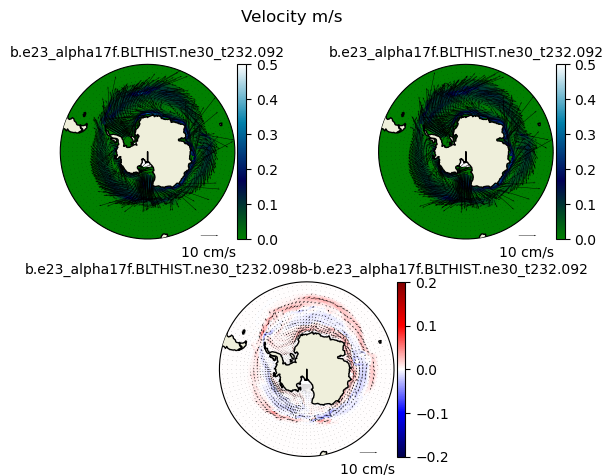

In [26]:
vect_diff(uvel1, vvel1, uvel2, vvel2, angle, "S", case1, case2, TLAT, TLON)